In [1]:
import numpy   as np
import pandas  as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing   import scale, StandardScaler
from sklearn.decomposition   import PCA, TruncatedSVD

import pickle

---

### Function Definition

In [2]:
def catPred(kmObj, gTrue, pred): 
    '''
        kmObjn: a kmeans object
        gTrue: true categories (ground truth)
    '''
    fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(50,12))

    numClusters = kmObj.get_params()['n_clusters']
    
    for i in range(numClusters):
        mask = (pred == i)
        val = np.unique( gTrue[mask], return_counts=True)
        lbl = val[0]
        ht  = val[1] / val[1].sum()
        ax[i].bar(range(numClusters), height=ht, tick_label = lbl)
        ax[i].set_xticklabels(lbl, fontsize=20)
        ax[i].set_title(i, fontsize=20)

        ax[0].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8"], fontsize=20)
        ax[0].set_ylabel("Proportion", fontsize = 32);
        plt.suptitle("Proportion of Categories in each Clusterc", fontsize = 32);

In [40]:
def top_pred_words(kmObj, X_df, ftrs_list, pred, num_reviews=5, num_words=5): 
    '''
        kmObjn: a kmeans object
        gTrue: true categories (ground truth)
    '''
    
    num_words += 1
    numClusters = kmObj.get_params()['n_clusters']
    
    for i in range(numClusters):
        mask = (pred == i)
        
        rev_ind = [ind for ind, flag in enumerate(mask) if flag]
        
        sample_reviews = np.random.choice(rev_ind, num_reviews, replace=False)
        
        print("\nCluster ", i, " =====")
        for review in sample_reviews:
            indx = X_df[review,:].indices
            data = X_df[review,:].data
            
            termsVals = indx[data.argsort()][-1:-num_words:-1]
            
            terms = []
            for w in termsVals:
                terms.append(ftrs_list[w])
            print(terms)

In [4]:
def center_top_words(kmeans_model, svd_model, ftrs, num_words=10):
    '''
        Print out the top num_words for each of the centroids in the kmeans model, 
        after we return the centroids back in 'word space' using the inverse SVD 
        transformation
        
        input:
        kmeans_model -  kmeans model object
        svd_model - svd model object
        ftrs - the features from the TFIDF vectorizer
        num_words - number of words to display        
    '''
        
    num_words += 1
    
    ftrs_array = np.array(ftrs)

    centroids = svd_model.inverse_transform(kmeans_model.cluster_centers_)

    for c in centroids:
        ind = np.abs(c).argsort()
        ind = ind[-1:-num_words:-1]
        print(ftrs_array[ind], "\n")

---

### Large Pickled Dataset



In [5]:
df = pd.read_pickle("fiveCats.pkl")

In [6]:
X_df = df.drop('category', axis=1)
y_df = df['category']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [8]:
print( X_train.shape, X_test.shape)

(517403, 11) (221745, 11)


---

### Manipulate data sets

In [9]:
m_termTrans = pickle.load(open('pkl_tfidf.p','rb'))
m_svd = pickle.load(open('pkl_svd.p','rb'))
m_kmeans = pickle.load(open('pkl_kmeans.p','rb'))

#### Vectorize Review Text

In [10]:
X_train_term  = m_termTrans.transform(X_train['text'])

In [11]:
X_train_term.shape

(517403, 153378)

In [12]:
ftrs = m_termTrans.get_feature_names()

#### Reduce Dimensionality

In [13]:
X_train_term_svd = m_svd.transform(X_train_term)

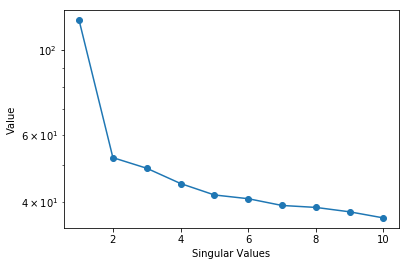

In [39]:
s = m_svd.singular_values_

x = [i+1 for i in range(len(s))]
plt.plot(x, s, marker='o')
plt.xlabel("Singular Values")
plt.ylabel("Value")
plt.yscale('log');

##### Percentage of Variance Explained

In [15]:
m_svd.explained_variance_ratio_.sum()*100

3.561945735071194

---

#### Cluster Reviews

In [16]:
X_test_term = m_termTrans.transform(X_test['text'])

In [17]:
X_test_term_svd = m_svd.transform(X_test_term)

In [18]:
X_test_term_svd.shape

(221745, 10)

In [19]:
pred = m_kmeans.predict(X_test_term_svd)

---

#### Visualize Clusters

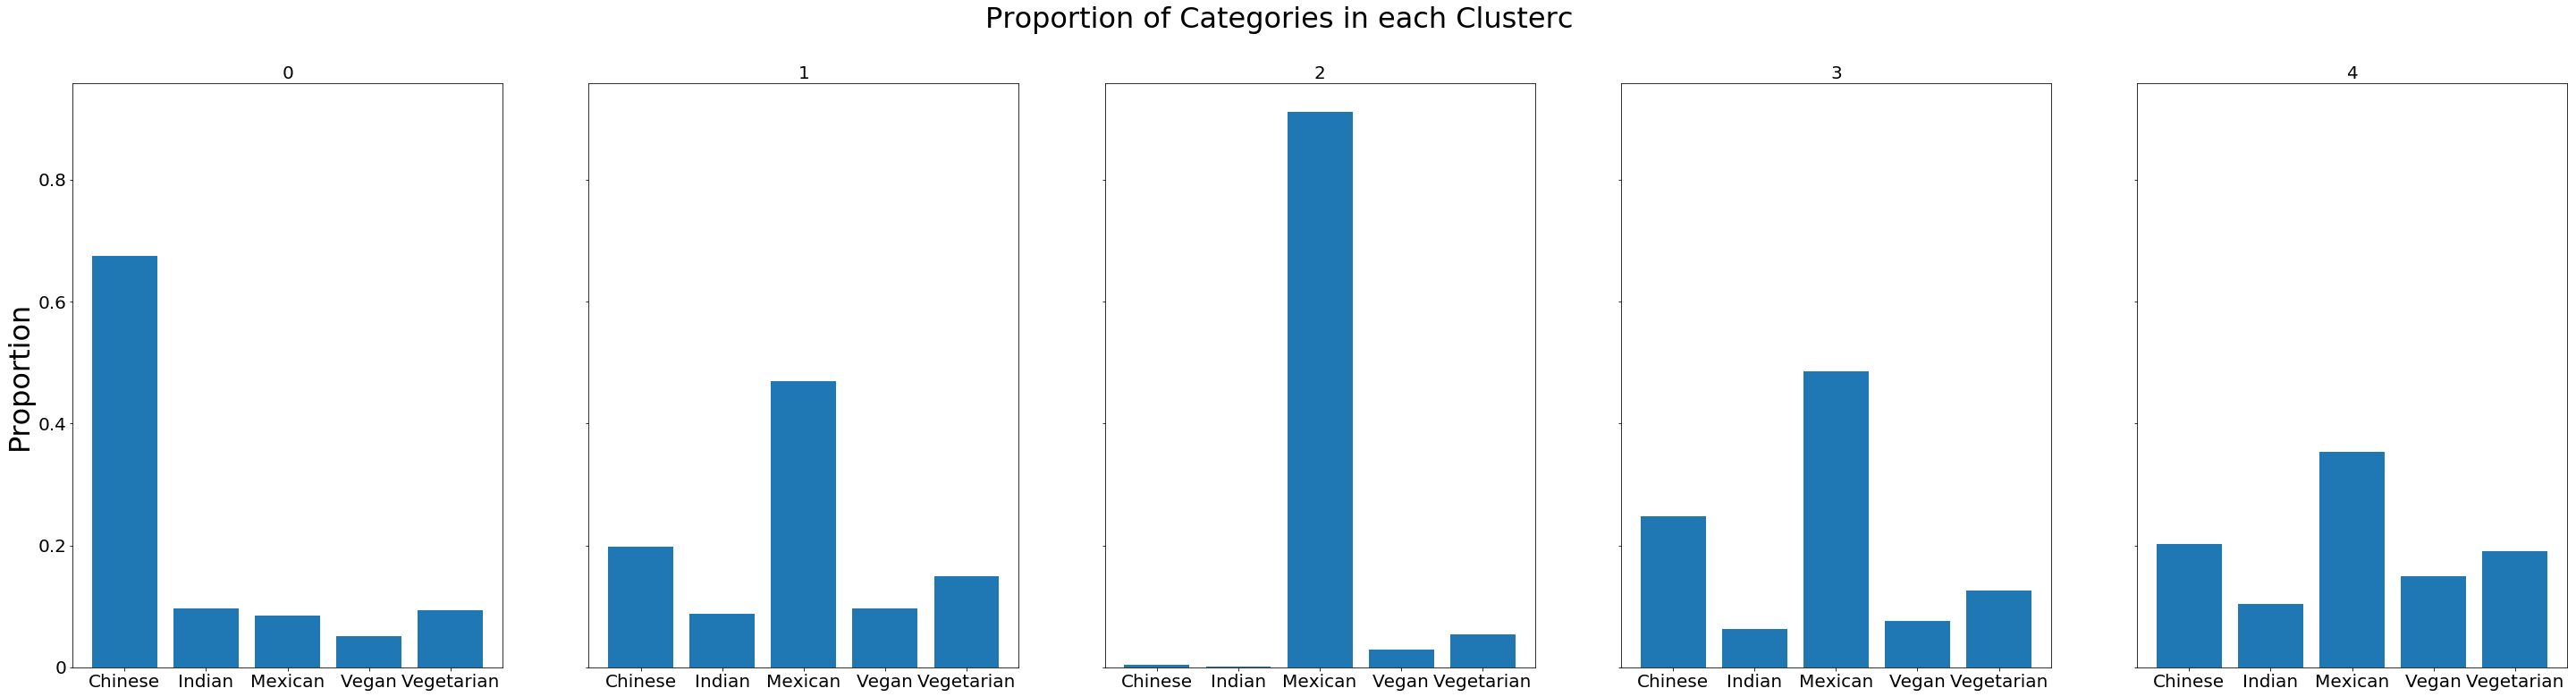

In [20]:
catPred(m_kmeans, y_test, pred)

In [41]:
top_pred_words(m_kmeans, X_test_term, ftrs, pred)


Cluster  0  =====
['rotis', 'gandhi', 'extras', 'peak', 'enjoyin']
['explosions', 'chicken', 'saag', 'closing', 'workers']
['samson', 'hai', 'nam', 'admit', 'got']
['wrap', 'shallots', 'wraps', 'spinach', '99']
['teppenyaki', 'choice', 'starting', 'includes', 'japanese']

Cluster  1  =====
['normal', 'prices', 'chinese', 'going', 'better']
['yay', 'spending', 'food', 'normally', 'door']
['names', 'upscale', 'sense', 'opened', 'remember']
['smoothies', 'gluten', 'stay', 'las', 'healthy']
['chrizo', 'poll', 'unwind', 'tostadas', 'en']

Cluster  2  =====
['border', 'close', 'disconnected', 'aliante', 'sd']
['chips', 'instead', 'salsa', 'flour', 'different']
['cravings', 'tacos', 'freshly', 'late', 'burritos']
['daughters', 'asks', 'tacos', 'verde', 'daughter']
['smoothies', '24', 'bomb', 'lime', 'cilantro']

Cluster  3  =====
['sullivan', 'upstream', 'charlotteans', 'wine', 'environments']
['tequila', 'mixed', 'spicy', 'margarita', 'ribs']
['beer', 'somewhat', 'canadian', 'late', 'broken

#### Test Set: Class Balance

In [22]:
y_test.value_counts()

Mexican       90867
Chinese       58894
Vegetarian    31696
Vegan         22109
Indian        18179
Name: category, dtype: int64

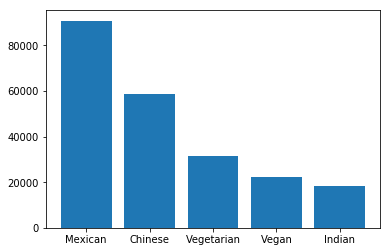

In [23]:
x = y_test.value_counts().values
lbls = list(y_test.value_counts().index)
plt.bar(range(len(x)), height=x, tick_label = lbls);

#### Train Set: Class Balance

In [24]:
y_train.value_counts()

Mexican       211010
Chinese       138128
Vegetarian     74094
Vegan          51344
Indian         42827
Name: category, dtype: int64

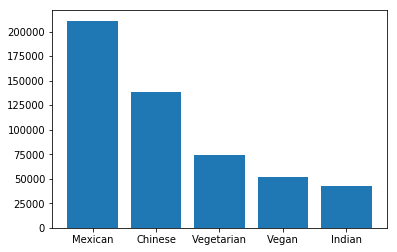

In [25]:
x = y_train.value_counts().values
lbls = list(y_train.value_counts().index)
plt.bar(range(len(x)), height=x, tick_label = lbls);

---

### Train data PREDICTION

In [26]:
pred2 = m_kmeans.predict(X_train_term_svd)

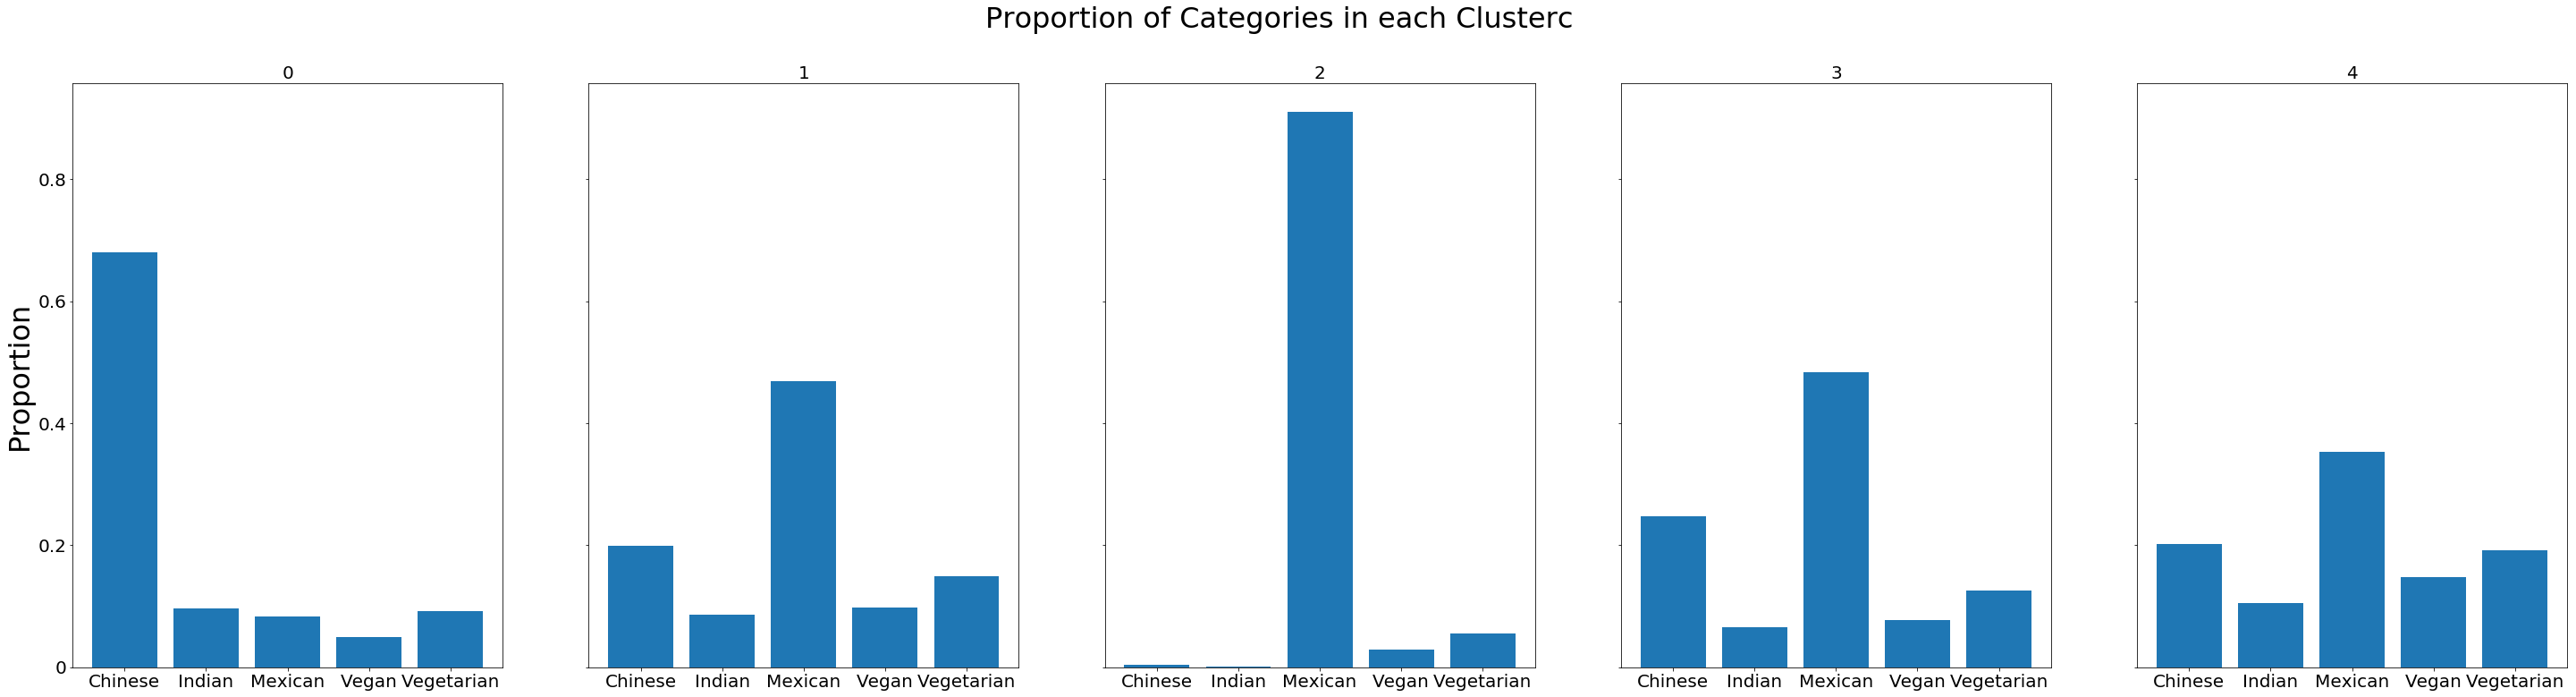

In [27]:
catPred(m_kmeans, y_train, pred2)

In [28]:
top_pred_words(m_kmeans, X_train_term, ftrs, pred2)


Cluster  0  =====
['sweet', 'mounds', 'dish', 'potato', 'poached']
['descriptive', 'tamari', 'diary', 'tweaked', 'item']
['struggle', 'completely', 'meat', 'salt', 'ginger']
['breaded', 'heavily', 'chicken', 'thai', 'mango']
['january', 'launch', 'classmates', 'semester', 'seneca']

Cluster  1  =====
['times', 'enjoy', 'horrible', 'complaint', 'handful']
['moved', 'love', 'ignored', 'worry', 'sticks']
['crowded', 'ambience', 'thoroughly', 'byob', 'buzzing']
['ve', 'average', 'margarita', 'banana', 'unbelievable']
['margaritas', 'tasting', 'despite', 'stale', 'awful']

Cluster  2  =====
['fish', 'husband', 'asada', 'ordered', 'taco']
['belly', 'bottle', 'mini', 'app', 'ghost']
['toppings', 'normally', 'hair', 'grub', 'hub']
['burgers', 'tacos', 'atrocious', 'remotely', 'speaker']
['carne', 'strongly', 'disagree', 'ok', 'asada']

Cluster  3  =====
['soon', 'stick', 'east', 'anytime', 'okay']
['353pm', '404pm', 'called', 'deliver', 'address']
['culiacán', 'salsa', 'aftertaste', '70s', 'a

---

### Top Words for Cluster Centroids

In [29]:
center_top_words(m_kmeans, m_svd, ftrs, 15)

['chicken' 'rice' 'good' 'chinese' 'food' 'fried' 'soup' 'beef' 'ordered'
 'like' 'place' 'sauce' 'noodles' 'pork' 'spicy'] 

['great' 'food' 'service' 'place' 'good' 'friendly' 'love' 'staff'
 'amazing' 'mexican' 'delicious' 'atmosphere' 'definitely' 'excellent'
 'recommend'] 

['tacos' 'taco' 'good' 'salsa' 'best' 'place' 'asada' 'mexican' 'fish'
 'great' 'carne' 'chips' 'food' 'really' 've'] 

['food' 'time' 'order' 'service' 'just' 'like' 'good' 'place' 'ordered'
 'got' 'minutes' 'came' 'don' 'didn' 'really'] 

['food' 'place' 'good' 'love' 'delicious' 'really' 'like' 'restaurant'
 'friendly' 'staff' 'best' 've' 'just' 'vegan' 'amazing'] 



# === === === === === === === === === === === === === === === 

In [30]:
# https://github.com/gSchool/dsi-solns-g69/blob/master/clustering/pair_part1_kmeans.py

In [31]:
pred

array([4, 4, 3, ..., 1, 3, 0], dtype=int32)

In [32]:
# Print out the reviews of a random sample of the restaurants assigned to each
# cluster to get a sense of the category.

print("\nRandom sample of reviews in each cluster")
assigned_cluster = m_kmeans.transform(X_train_term_svd)


Random sample of reviews in each cluster


In [33]:
assigned_cluster[:5,:]

array([[0.26588994, 0.29185698, 0.34204606, 0.3132903 , 0.274932  ],
       [0.20560888, 0.21045983, 0.11293747, 0.16625567, 0.16556317],
       [0.17205373, 0.26120403, 0.29628617, 0.24536429, 0.2288949 ],
       [0.17621975, 0.23184859, 0.21736433, 0.10359432, 0.11218354],
       [0.23078678, 0.24855763, 0.28373133, 0.22483054, 0.1799186 ]])

In [34]:
assigned_cluster = assigned_cluster[:10,:].argmin(axis=1)
assigned_cluster

array([0, 2, 0, 3, 4, 4, 4, 0, 0, 1])

In [35]:
pred2[:10]

array([0, 2, 0, 3, 4, 4, 4, 0, 0, 1], dtype=int32)

In [36]:
m_kmeans.cluster_centers_

array([[ 0.18228339, -0.07692559, -0.04838772,  0.06779744,  0.00767893,
         0.01091632, -0.018     , -0.01984398,  0.00185338,  0.00500899],
       [ 0.18857081,  0.11460932, -0.03383267,  0.00410074, -0.00445603,
         0.03475242, -0.00763856, -0.00889979, -0.01211165,  0.00153124],
       [ 0.18041927,  0.01580211,  0.14842673,  0.03129908,  0.01417226,
        -0.00342476, -0.01493756,  0.00080862,  0.04285377,  0.01111897],
       [ 0.17438382, -0.04084372,  0.00193105, -0.07978318, -0.01179172,
         0.00641159, -0.01008459,  0.00038248, -0.00527562,  0.0100825 ],
       [ 0.12161112,  0.00383308, -0.00714448, -0.00041162, -0.00714538,
        -0.02277857,  0.01963952,  0.01033667, -0.00295419, -0.01292969]])